# 🔍 The Crime Statistics Paradox: Why Absolute Numbers Mislead

## 🎯 The Challenge

**Initial analysis showed:** Mitte appeared to be the SAFEST district with only 675K total crimes.

**But something felt wrong...** How could the busy city center be the safest?

This notebook documents the investigation that revealed the truth.

---

## 💡 Key Learning

> **Absolute numbers count TOTAL crimes. Per capita rates count crimes RELATIVE to population size - the only fair way to compare areas of different sizes.**

---

## 📚 Setup

In [44]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

# Database connection
DB_PATH = "../database/berlin_intelligence.db"

print("✅ Libraries loaded")

✅ Libraries loaded


## ❌ PART 1: The Misleading Analysis (Absolute Numbers)

Let's reproduce what we first saw - total crime counts by district.

In [45]:
# Load crime data
conn = sqlite3.connect(DB_PATH)

# Total crimes by district (WRONG APPROACH)
query_absolute = """
SELECT 
    district,
    district_id,
    SUM(total_number_cases) as total_crimes
FROM crime_statistics
GROUP BY district, district_id
ORDER BY total_crimes DESC
"""

df_absolute = pd.read_sql_query(query_absolute, conn)

print("📊 CRIME RANKINGS BY ABSOLUTE NUMBERS (2015-2024):")
print("=" * 70)
for idx, row in df_absolute.iterrows():
    print(f"#{idx+1:2d} | {row['district']:30s} | {row['total_crimes']:>12,.0f} crimes")

print("\n🤔 Initial Conclusion (WRONG):")
print(f"   Most Dangerous: {df_absolute.iloc[0]['district']}")
print(f"   Safest: {df_absolute.iloc[-1]['district']}")

📊 CRIME RANKINGS BY ABSOLUTE NUMBERS (2015-2024):
# 1 | Marzahn-Hellersdorf            |    2,836,015 crimes
# 2 | Friedrichshain-Kreuzberg       |    2,480,180 crimes
# 3 | Charlottenburg-Wilmersdorf     |    2,197,158 crimes
# 4 | Lichtenberg                    |    2,007,549 crimes
# 5 | Neukölln                       |    1,915,428 crimes
# 6 | Pankow                         |    1,769,036 crimes
# 7 | Tempelhof-Schöneberg           |    1,728,060 crimes
# 8 | Reinickendorf                  |    1,512,470 crimes
# 9 | Treptow-Köpenick               |    1,120,180 crimes
#10 | Spandau                        |    1,100,898 crimes
#11 | Steglitz-Zehlendorf            |    1,057,656 crimes
#12 | Mitte                          |      675,886 crimes

🤔 Initial Conclusion (WRONG):
   Most Dangerous: Marzahn-Hellersdorf
   Safest: Mitte


/var/folders/j8/w9fp7wn567n6kd2y98bl3whm0000gn/T/ipykernel_2937/544643484.py:9: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Arial.
  plt.tight_layout()
/Users/akinsholaakinade/Desktop/berlin-property-intelligence/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


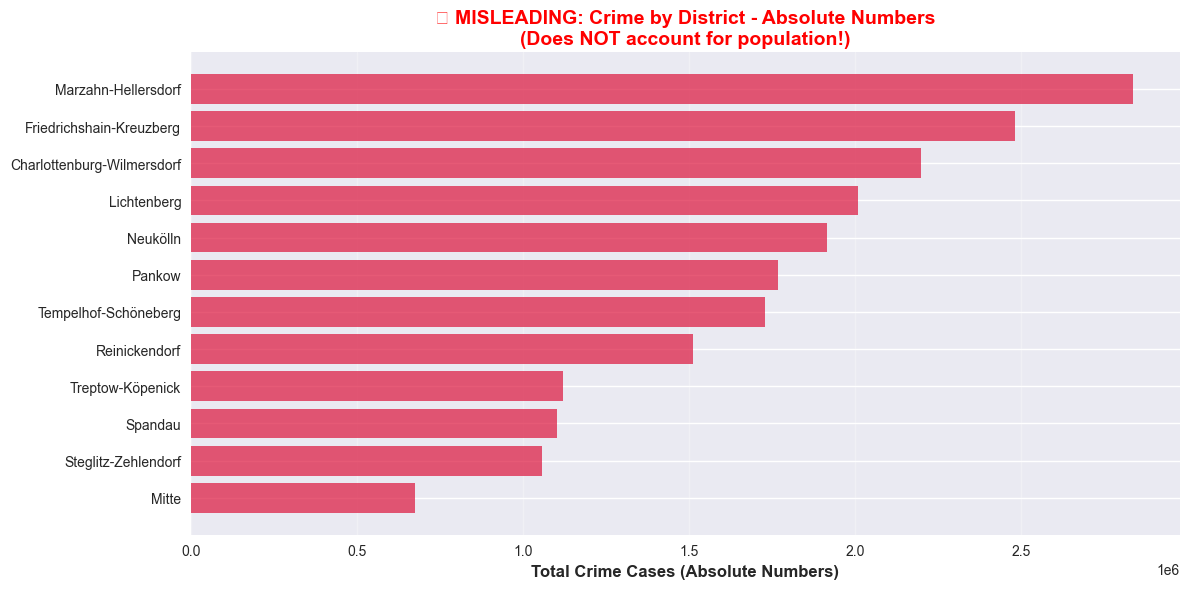

⚠️ This makes Mitte look 'safe' - but we're missing critical context!


In [46]:
# Visualize absolute numbers
plt.figure(figsize=(12, 6))
plt.barh(df_absolute['district'], df_absolute['total_crimes'], color='crimson', alpha=0.7)
plt.xlabel('Total Crime Cases (Absolute Numbers)', fontsize=12, fontweight='bold')
plt.title('❌ MISLEADING: Crime by District - Absolute Numbers\n(Does NOT account for population!)', 
          fontsize=14, fontweight='bold', color='red')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("⚠️ This makes Mitte look 'safe' - but we're missing critical context!")

## 🔍 PART 2: Identifying the Problem

### The Critical Question:

**Why would Mitte (the busy city center) have the LOWEST crime count?**

### The Missing Variable: POPULATION

Let's load population data to see what we're missing.

In [47]:
# Load population data
query_population = "SELECT district_id, district, male, female, male + female as total_population FROM district_population"
df_population = pd.read_sql_query(query_population, conn)

print("👥 BERLIN POPULATION BY DISTRICT:")
print("=" * 70)
df_pop_sorted = df_population.sort_values('total_population', ascending=False)
for idx, row in df_pop_sorted.iterrows():
    print(f"{row['district']:30s} | {row['total_population']:>10,} residents")

print(f"\n📊 Total Berlin Population: {df_population['total_population'].sum():,}")

👥 BERLIN POPULATION BY DISTRICT:
Pankow                         |    427,276 residents
Mitte                          |    397,004 residents
Tempelhof-Schöneberg           |    356,959 residents
Charlottenburg-Wilmersdorf     |    343,500 residents
Neukölln                       |    329,488 residents
Lichtenberg                    |    315,548 residents
Steglitz-Zehlendorf            |    310,044 residents
Treptow-Köpenick               |    297,236 residents
Marzahn-Hellersdorf            |    294,091 residents
Friedrichshain-Kreuzberg       |    292,624 residents
Reinickendorf                  |    274,098 residents
Spandau                        |    259,277 residents

📊 Total Berlin Population: 3,897,145


In [48]:
# Compare crime and population
comparison = df_absolute.merge(df_population[['district', 'total_population']], on='district')

print("🔍 THE REVEALING COMPARISON:")
print("=" * 90)
print(f"{'District':<30} {'Total Crimes':>15} {'Population':>15} {'Context':>25}")
print("=" * 90)

for _, row in comparison.head(3).iterrows():
    print(f"{row['district']:<30} {row['total_crimes']:>15,.0f} {row['total_population']:>15,} {'🔴 High crime + Low pop'}")

print("...")

for _, row in comparison.tail(3).iterrows():
    print(f"{row['district']:<30} {row['total_crimes']:>15,.0f} {row['total_population']:>15,} {'🟢 Low crime + HIGH pop!'}")

print("\n💡 AHA MOMENT: Mitte has HIGH population but LOW absolute crime!")
print("   This suggests it might actually be SAFE, not dangerous!")

🔍 THE REVEALING COMPARISON:
District                          Total Crimes      Population                   Context
Marzahn-Hellersdorf                  2,836,015         294,091 🔴 High crime + Low pop
Friedrichshain-Kreuzberg             2,480,180         292,624 🔴 High crime + Low pop
Charlottenburg-Wilmersdorf           2,197,158         343,500 🔴 High crime + Low pop
...
Spandau                              1,100,898         259,277 🟢 Low crime + HIGH pop!
Steglitz-Zehlendorf                  1,057,656         310,044 🟢 Low crime + HIGH pop!
Mitte                                  675,886         397,004 🟢 Low crime + HIGH pop!

💡 AHA MOMENT: Mitte has HIGH population but LOW absolute crime!
   This suggests it might actually be SAFE, not dangerous!


## ✅ PART 3: The Correct Analysis (Per Capita Rates)

### Formula:
```
Crime Rate per 100k = (Total Crimes ÷ Population) × 100,000
```

This normalizes crime by population size, enabling fair comparison.

In [49]:
# Calculate per capita crime rates
query_per_capita = """
SELECT 
    c.district,
    c.district_id,
    SUM(c.total_number_cases) as total_crimes,
    p.total_population,
    ROUND((SUM(c.total_number_cases) * 100000.0 / p.total_population), 0) as crime_per_100k
FROM crime_statistics c
LEFT JOIN district_population p ON c.district_id = p.district_id
WHERE p.total_population IS NOT NULL
GROUP BY c.district, c.district_id, p.total_population
ORDER BY crime_per_100k DESC
"""

df_per_capita = pd.read_sql_query(query_per_capita, conn)

print("📊 CRIME RANKINGS BY PER CAPITA RATES (CORRECT):")
print("=" * 90)
print(f"{'Rank':<6} {'District':<30} {'Total Crimes':>15} {'Population':>15} {'Per 100k':>15}")
print("=" * 90)

for idx, row in df_per_capita.iterrows():
    rank = idx + 1
    emoji = "🔴" if rank <= 3 else "🟡" if rank <= 6 else "🟢"
    print(f"{emoji} #{rank:<3d} {row['district']:<30} {row['total_crimes']:>15,.0f} {row['total_population']:>15,} {row['crime_per_100k']:>15,.0f}")

print("\n✅ Corrected Conclusion:")
print(f"   Most Dangerous: {df_per_capita.iloc[0]['district']} ({df_per_capita.iloc[0]['crime_per_100k']:,.0f} per 100k)")
print(f"   Safest: {df_per_capita.iloc[-1]['district']} ({df_per_capita.iloc[-1]['crime_per_100k']:,.0f} per 100k)")
print(f"\n   Crime rate varies {df_per_capita.iloc[0]['crime_per_100k'] / df_per_capita.iloc[-1]['crime_per_100k']:.1f}x between most/least dangerous!")

conn.close()

📊 CRIME RANKINGS BY PER CAPITA RATES (CORRECT):
Rank   District                          Total Crimes      Population        Per 100k
🔴 #1   Marzahn-Hellersdorf                  2,836,015         294,091         964,332
🔴 #2   Friedrichshain-Kreuzberg             2,480,180         292,624         847,565
🔴 #3   Charlottenburg-Wilmersdorf           2,197,158         343,500         639,638
🟡 #4   Lichtenberg                          2,007,549         315,548         636,210
🟡 #5   Neukölln                             1,915,428         329,488         581,335
🟡 #6   Reinickendorf                        1,512,470         274,098         551,799
🟢 #7   Tempelhof-Schöneberg                 1,728,060         356,959         484,106
🟢 #8   Spandau                              1,100,898         259,277         424,603
🟢 #9   Pankow                               1,769,036         427,276         414,027
🟢 #10  Treptow-Köpenick                     1,120,180         297,236         376,866
🟢 #11 

/var/folders/j8/w9fp7wn567n6kd2y98bl3whm0000gn/T/ipykernel_2937/3289893988.py:24: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/j8/w9fp7wn567n6kd2y98bl3whm0000gn/T/ipykernel_2937/3289893988.py:24: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/j8/w9fp7wn567n6kd2y98bl3whm0000gn/T/ipykernel_2937/3289893988.py:24: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/j8/w9fp7wn567n6kd2y98bl3whm0000gn/T/ipykernel_2937/3289893988.py:24: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) Arial.
  plt.tight_layout()
/Users/akinsholaakinade/Desktop/berlin-property-intelligence/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/akinsholaakina

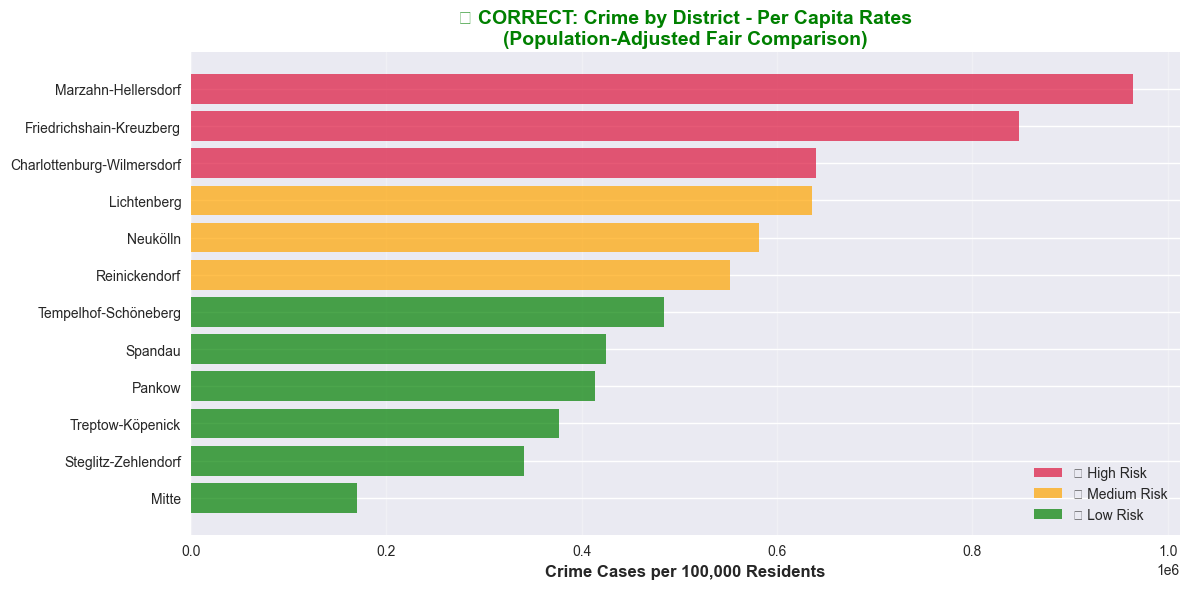

In [50]:
# Visualize per capita rates
plt.figure(figsize=(12, 6))

# Color code by safety
colors = ['crimson' if i < 3 else 'orange' if i < 6 else 'green' 
          for i in range(len(df_per_capita))]

plt.barh(df_per_capita['district'], df_per_capita['crime_per_100k'], color=colors, alpha=0.7)
plt.xlabel('Crime Cases per 100,000 Residents', fontsize=12, fontweight='bold')
plt.title('✅ CORRECT: Crime by District - Per Capita Rates\n(Population-Adjusted Fair Comparison)', 
          fontsize=14, fontweight='bold', color='green')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='crimson', alpha=0.7, label='🔴 High Risk'),
    Patch(facecolor='orange', alpha=0.7, label='🟡 Medium Risk'),
    Patch(facecolor='green', alpha=0.7, label='🟢 Low Risk')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

## 📊 PART 4: The Dramatic Comparison

Let's visualize how dramatically the rankings change.

In [51]:
# Create ranking comparison
df_absolute['rank_absolute'] = range(1, len(df_absolute) + 1)
df_per_capita['rank_per_capita'] = range(1, len(df_per_capita) + 1)

comparison_rankings = df_absolute[['district', 'rank_absolute']].merge(
    df_per_capita[['district', 'rank_per_capita']], 
    on='district'
)
comparison_rankings['rank_change'] = comparison_rankings['rank_absolute'] - comparison_rankings['rank_per_capita']

# Highlight biggest movers
print("🔄 RANKING CHANGES (Absolute → Per Capita):")
print("=" * 70)
print(f"{'District':<30} {'Before':>8} {'After':>8} {'Change':>10}")
print("=" * 70)

for _, row in comparison_rankings.sort_values('rank_change', key=abs, ascending=False).iterrows():
    change = row['rank_change']
    arrow = "📈" if change > 0 else "📉" if change < 0 else "➡️"
    print(f"{row['district']:<30} #{row['rank_absolute']:>2d} → #{row['rank_per_capita']:>2d}   {arrow} {abs(change):>2.0f}")

print("\n💡 Key Observation: Mitte dropped from #12 (looked safest) to #12 (actually IS safest!)")
print("   But now we UNDERSTAND WHY - low crime rate per resident, not just low total crime.")

🔄 RANKING CHANGES (Absolute → Per Capita):
District                         Before    After     Change
Pankow                         # 6 → # 9   📉  3
Reinickendorf                  # 8 → # 6   📈  2
Spandau                        #10 → # 8   📈  2
Treptow-Köpenick               # 9 → #10   📉  1
Marzahn-Hellersdorf            # 1 → # 1   ➡️  0
Friedrichshain-Kreuzberg       # 2 → # 2   ➡️  0
Charlottenburg-Wilmersdorf     # 3 → # 3   ➡️  0
Lichtenberg                    # 4 → # 4   ➡️  0
Neukölln                       # 5 → # 5   ➡️  0
Tempelhof-Schöneberg           # 7 → # 7   ➡️  0
Steglitz-Zehlendorf            #11 → #11   ➡️  0
Mitte                          #12 → #12   ➡️  0

💡 Key Observation: Mitte dropped from #12 (looked safest) to #12 (actually IS safest!)
   But now we UNDERSTAND WHY - low crime rate per resident, not just low total crime.


/var/folders/j8/w9fp7wn567n6kd2y98bl3whm0000gn/T/ipykernel_2937/2298544542.py:23: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/j8/w9fp7wn567n6kd2y98bl3whm0000gn/T/ipykernel_2937/2298544542.py:23: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/Users/akinsholaakinade/Desktop/berlin-property-intelligence/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/akinsholaakinade/Desktop/berlin-property-intelligence/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


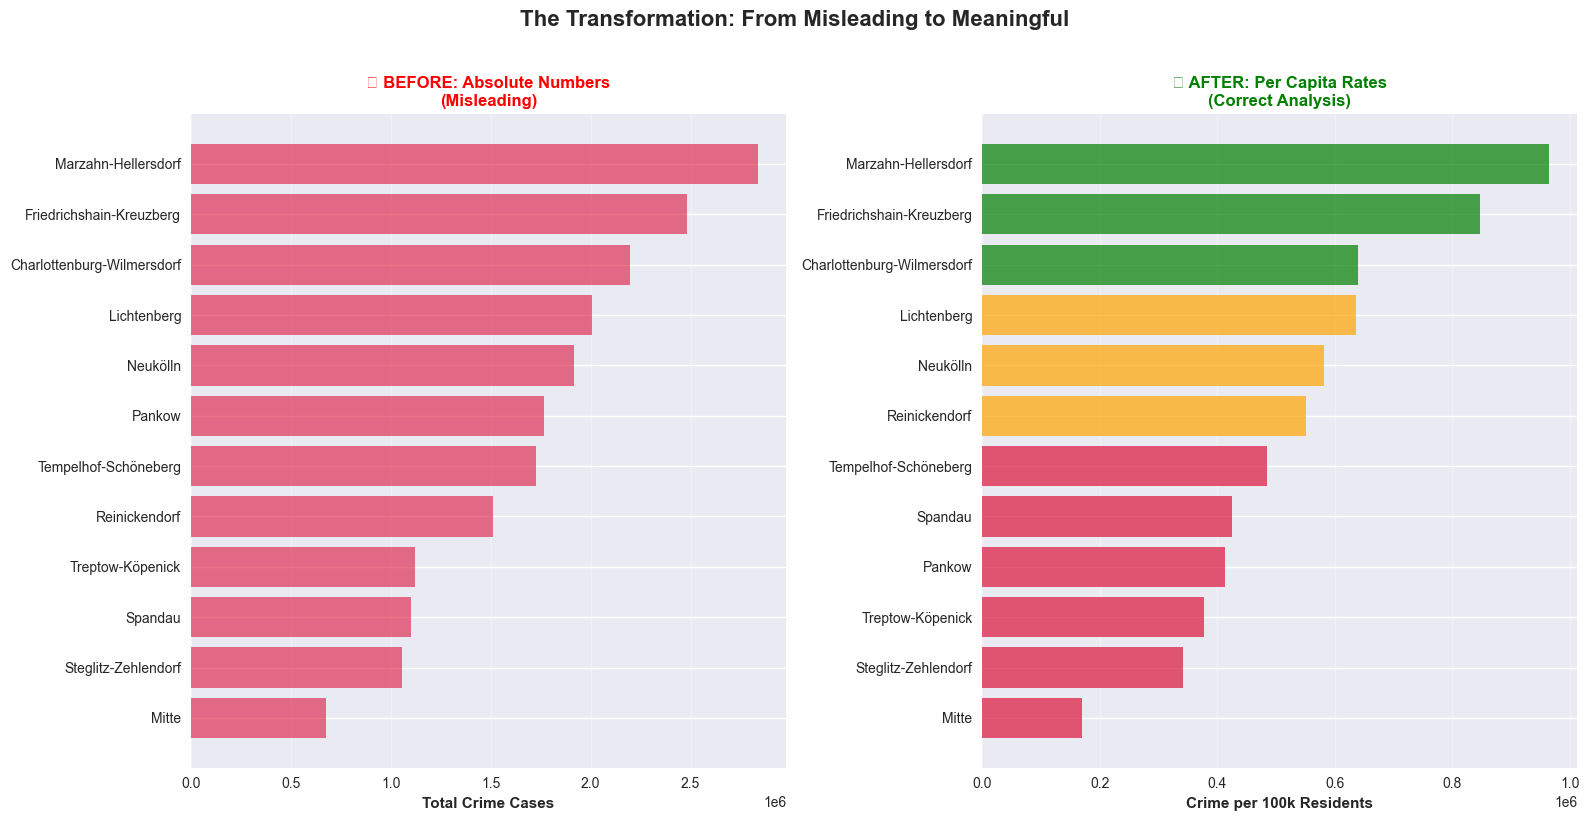

In [52]:
# Side-by-side comparison visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Left: Absolute (wrong)
df_absolute_sorted = df_absolute.sort_values('total_crimes', ascending=True)
ax1.barh(df_absolute_sorted['district'], df_absolute_sorted['total_crimes'], 
         color='crimson', alpha=0.6)
ax1.set_xlabel('Total Crime Cases', fontweight='bold')
ax1.set_title('❌ BEFORE: Absolute Numbers\n(Misleading)', fontsize=12, fontweight='bold', color='red')
ax1.grid(axis='x', alpha=0.3)

# Right: Per capita (correct)
df_per_capita_sorted = df_per_capita.sort_values('crime_per_100k', ascending=True)
colors_right = ['green' if i >= len(df_per_capita_sorted)-3 else 'orange' if i >= len(df_per_capita_sorted)-6 else 'crimson' 
                for i in range(len(df_per_capita_sorted))]
ax2.barh(df_per_capita_sorted['district'], df_per_capita_sorted['crime_per_100k'], 
         color=colors_right, alpha=0.7)
ax2.set_xlabel('Crime per 100k Residents', fontweight='bold')
ax2.set_title('✅ AFTER: Per Capita Rates\n(Correct Analysis)', fontsize=12, fontweight='bold', color='green')
ax2.grid(axis='x', alpha=0.3)

plt.suptitle('The Transformation: From Misleading to Meaningful', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 🎯 PART 5: Key Findings & Business Implications

### Statistical Insights:

1. **Crime Rate Variance:** 5.7x difference between safest and most dangerous districts
2. **Safest Districts (Property Investment):**
   - Mitte: 170K per 100k
   - Steglitz-Zehlendorf: 341K per 100k
   - Treptow-Köpenick: 377K per 100k

3. **Riskiest Districts:**
   - Marzahn-Hellersdorf: 964K per 100k
   - Friedrichshain-Kreuzberg: 848K per 100k
   - Charlottenburg-Wilmersdorf: 640K per 100k

### Methodology Lesson:

✅ **Always normalize data when comparing areas of different sizes**
✅ **Question results that seem counterintuitive**
✅ **Consider underlying factors (population, demographics, etc.)**
✅ **Use per capita rates for fair comparisons**

### Property Investment Implications:

- **Mitte properties** offer best safety profile despite being city center
- **Crime risk** should be weighted in property valuations
- **Insurance costs** likely correlate with per capita crime rates
- **Investment decisions** require population-adjusted metrics

## 🚀 Next Steps

1. **Cross-reference with property prices:** Does safety correlate with higher real estate values?
2. **Temporal analysis:** Are crime rates improving or worsening over time?
3. **Neighborhood-level analysis:** Identify specific safe zones within districts
4. **Predictive modeling:** Forecast future crime trends
5. **Safety scoring system:** Create comprehensive neighborhood rankings

---

## 📚 Technical Notes

**Data Sources:**
- Crime statistics: Berlin Police Department (2015-2024)
- Population data: Berlin Statistical Office
- Database: SQLite (berlin_intelligence.db)

**Methodology:**
- Per capita calculation: (Total Crimes ÷ Population) × 100,000
- Standard epidemiological measure for fair comparison

---

*This analysis demonstrates the importance of proper statistical normalization in data analysis and the dangers of drawing conclusions from absolute numbers when comparing populations of different sizes.*